In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Here we will fine-tune a pre-trained image classification model for this specific task, evaluate it, and perform inference on unseen data using the PyTorch framework in Python.

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt

import cv2
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os

from types import SimpleNamespace

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import random
from tqdm import tqdm

In [28]:
import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

In [29]:
print(torch.__version__)
print(cv2.__version__)
print(A.__version__)

2.0.0
4.5.4
1.3.0


### LOAD DATA

In [30]:
dataset='../input/vegetable-image-dataset/Vegetable Images'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

In [31]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
print("\n\nTRAIN FOLDER \n\n")            
count_files(os.path.join(train_folder))
print("\n\nTEST FOLDER \n\n") 
count_files(os.path.join(test_folder))
print("\n\nVALIDATION FOLDER \n\n") 
count_files(os.path.join(validation_folder))



TRAIN FOLDER 


There are 1000 files in Broccoli
There are 1000 files in Capsicum
There are 1000 files in Bottle_Gourd
There are 1000 files in Radish
There are 1000 files in Tomato
There are 1000 files in Brinjal
There are 1000 files in Pumpkin
There are 1000 files in Carrot
There are 1000 files in Papaya
There are 1000 files in Cabbage
There are 1000 files in Bitter_Gourd
There are 1000 files in Cauliflower
There are 1000 files in Bean
There are 1000 files in Cucumber
There are 1000 files in Potato


TEST FOLDER 


There are 200 files in Broccoli
There are 200 files in Capsicum
There are 200 files in Bottle_Gourd
There are 200 files in Radish
There are 200 files in Tomato
There are 200 files in Brinjal
There are 200 files in Pumpkin
There are 200 files in Carrot
There are 200 files in Papaya
There are 200 files in Cabbage
There are 200 files in Bitter_Gourd
There are 200 files in Cauliflower
There are 200 files in Bean
There are 200 files in Cucumber
There are 200 files in Potato




As evident, Dataset is well balanced with each class containing :
- 1000 images for training set.
- 200 images for test set.

### PREPROCESSING

The goal of image processing is improvement of pictorial information for human interpretation. Basic manipulation and filtering can lead to increased understanding for feature extraction as well.


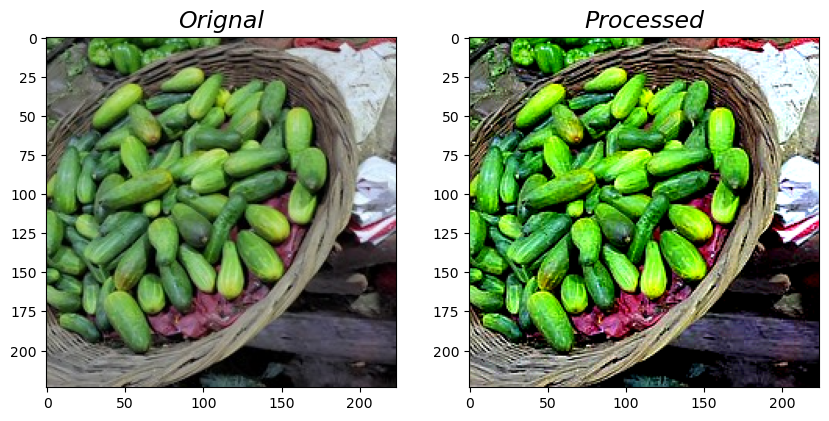

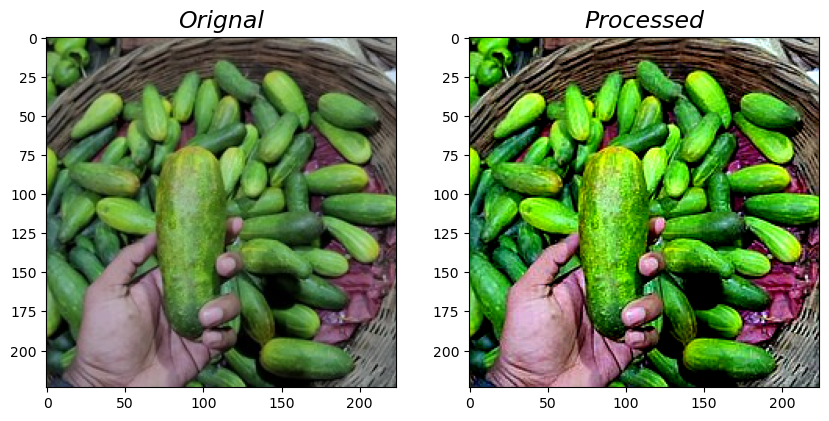

In [6]:
image_folder="Cucumber"  # The vegetable you want to display
number_of_images=2       # Number of images to display

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1
        
Preprocess()

We increased the color saturation, contrast and finally sharpened the image for drawing texture and viewer focus. The image after processing looks appealing and brighter

### EDA

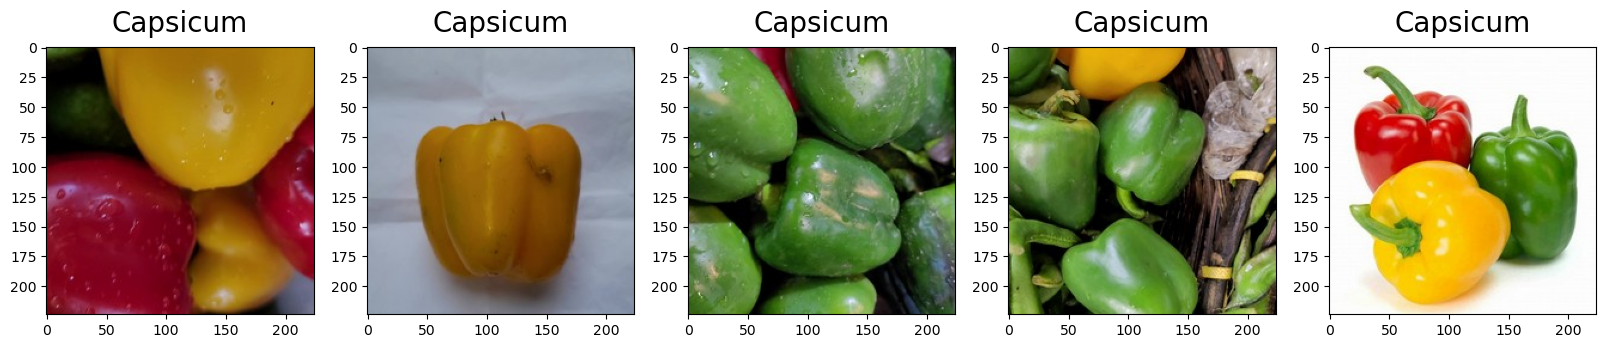

In [7]:
select_vegetable="Capsicum"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

Now let's visualize the whole dataset by picking a random image from each class inside training dataset.

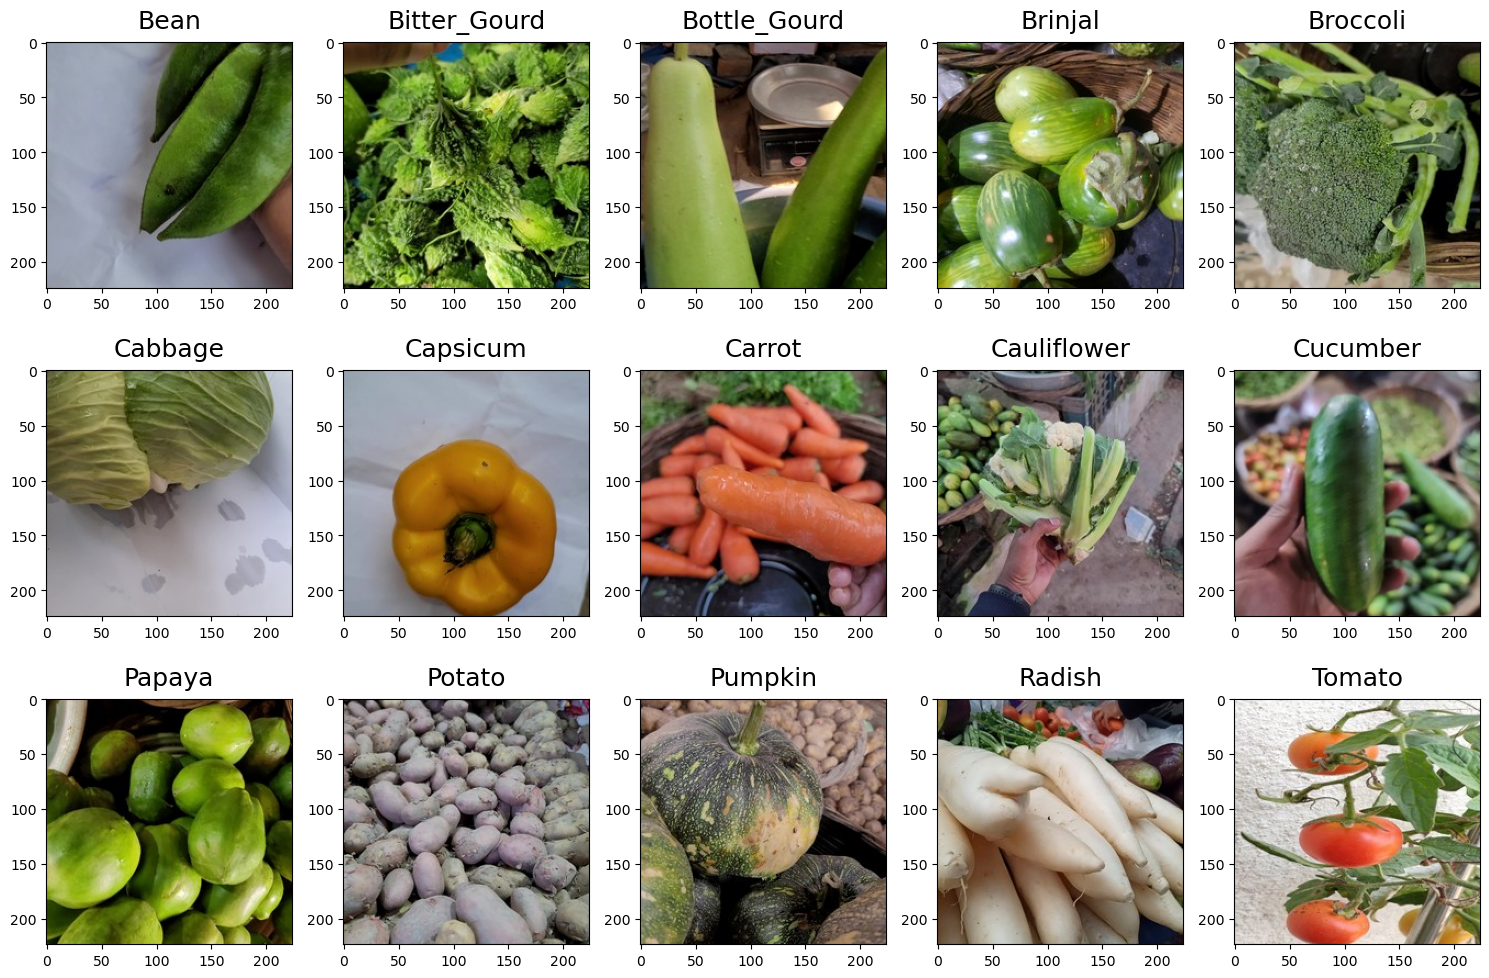

In [8]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

### Build a Baseline

Three components of a baseline:
- A data pipeline for loading images
- A model with loss function and optimizer
- A training pipeline, including a cross-validation strategy

Because training a Deep Learning model includes a lot of experimentation, we want to be able to switch out specific parts of the code quickly. Thus, we will try to make the following code as modular as possible and work with a CONFIGURATION for tuning:

In [47]:
# Code copied and edited from https://github.com/pascal-pfeiffer/kaggle-birdclef2021-2nd-place/blob/main/configs/default_config.py
cfg = SimpleNamespace(**{}) # This line creates a new object named cfg of the class SimpleNamespace. 
#The SimpleNamespace class is a simple container for creating objects that allows setting attributes using keyword arguments.

# paths
cfg.train_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train/'
cfg.test_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test/'
cfg.val_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/'

# dataset
cfg.n_classes = 15
cfg.batch_size = 32
cfg.image_size = 224

# img model
cfg.backbone = "resnet18"
cfg.pretrained = True
cfg.pretrained_weights = None

# training
cfg.learning_rate = 1e-4
cfg.lr_min = 1e-5
cfg.epochs = 5
cfg.seed = 42
cfg.n_folds = 3 

# ressources
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg.num_workers = 4

The main objective of the above code is to define and configure a set of parameters and settings for a deep learning model or training process. These parameters and settings are stored in the cfg object, which serves as a configuration container.

The cfg object encapsulates various aspects of the model and training process, such as dataset paths, model architecture, hyperparameters (e.g., learning rate, batch size, epochs), device selection, and resource allocation.

#### Set seed for reproducibility

In [48]:
def set_seed(seed=1234):
    random.seed(seed)                # It ensures that any random functions called from this module will produce the same sequence of random numbers when the same seed is used.
    os.environ["PYTHONHASHSEED"] = str(seed)   #sets the random seed for the hash function used in Python's built-in data structures like dictionaries and sets
    np.random.seed(seed)   #It ensures reproducibility for any random functions called from NumPy, such as generating random arrays or sampling from distributions.
    
    # In general seed PyTorch operations
    torch.manual_seed(seed)  #ensures that operations involving random numbers, such as weight initialization or shuffling of data, will produce consistent results.
    
    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed) #sets the random seed for the random number generator in PyTorch on a single GPU (if available)
    
    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(cfg.seed) #  If you are using multiple GPUs, this line ensures that operations involving random numbers on all GPUs will produce consistent results.
    
    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True # setting this flag ensures consistent results at the cost of potential performance loss.
    
    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False #  disables the cuDNN auto-tuner, which optimizes performance by selecting the best algorithm for a given hardware configuration.

Build a data pipeline for loading images

First, we must build a pipeline to load, preprocess and feed your images to the neural network in batches (instead of all at once). PyTorch provides two core classes you can use for this purpose:

- Dataset class: Loads and preprocesses the dataset. You will need to customize this class for your purpose.
- Dataloader class: Loads batches of data samples to the neural network.

Customizing the Dataset class. Its key components are:

- Constructor: to load the dataset as, e.g., Pandas Dataframe
- __len__(): to get the length of the dataset. This usually will require minimal adjustments related to how you pass in the dataset.
- __getitem__(): to get a sample from the dataset by index. This is usually the part where you modify most of the code depending on any preprocessing you want to do.

When loading your dataset, you can also perform any required preprocessing, such as transforms or image standardization. This happens in __getitem__().

Here, we first load the image from the root directory (cfg.root_dir) with OpenCV and convert it to the RGB color space. Then we will apply basic transforms: Resize the image (cfg.image_size) and convert the image from a NumPy array to a tensor. Finally, we will normalize the values of the image to be in the [0, 1] range by dividing the values by 224.

In [49]:
class CustomDataset(Dataset):
    """cfg: The configuration object that contains various settings and parameters.
    df: A dataframe containing the dataset information, such as file names and labels.
    transform: An optional parameter representing the data transformation or augmentation pipeline to be applied to the images.
    mode: An optional parameter indicating the mode of the dataset, such as training or validation."""
    
    def __init__(self,                        # This is the initialization method of the CustomDataset class.
                 cfg, 
                 df, 
                 transform=None, 
                mode = "val"):
        self.train_dir = cfg.train_dir            # These lines assigns the directory path (stored in the cfg object) to the root_dir attribute of the CustomDataset object.
        self.test_dir = cfg.test_dir
        self.val_dir = cfg.val_dir
        self.df = df                              # This line assigns the provided dataframe (df) to the df attribute of the CustomDataset object
        self.file_names = df['file_name'].values  # This line extracts the 'file_name' column from the dataframe and assigns it to the file_names attribute
        self.labels = df['label'].values          # This line extracts the 'label' column from the dataframe and assigns it to the labels attribute.
        
        if transform:                             # This condition checks if a transformation pipeline (transform) has been provided as an argument during the initialization. 
                                                  # If a transformation is provided, it assigns it to the transform attribute of the object.                          
            self.transform = transform
        else:
            self.transform = A.Compose([                             ##Otherwise, it defines a default transformation pipeline using the A.Compose function from the albumentations library.
                              A.Resize(cfg.image_size, cfg.image_size), 
                              ToTensorV2(),
                           ])
        
    def __len__(self):            # This method returns the length of the dataset, which corresponds to the number of samples in the dataframe.
        return len(self.df)       # It is used when iterating over the dataset using a dataloader.
    
    def __getitem__(self, idx):   #  This method returns the sample at the given index. It is used to retrieve a specific sample from the dataset.
        # Get file_path and label for index
        label = self.labels[idx]
        train_file_path = os.path.join(self.train_dir, self.file_names[idx])  #
        test_file_path = os.path.join(self.test_dir, self.file_names[idx])
        val_file_path = os.path.join(self.val_dir, self.file_names[idx])
        
        # Read an image with OpenCV
        image = cv2.imread(train_file_path)  # reads the image using OpenCV based on the constructed file path.
        
        if image is not None and image.shape[0] > 0 and image.shape[1] > 0:
           # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        elif image is None:
            try:
                image = cv2.imread(val_file_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except Exception as e:
                image = cv2.imread(test_file_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        else:
            print("Invalid image dimensions or file not found.")
            

        # Apply augmentations
        augmented = self.transform(image=image)
        image = augmented['image']
            
        # Normalize because ToTensorV2() doesn't normalize the image
        image = image/224        # This operation is performed to bring the pixel values within the range [0, 1], assuming that the original pixel values were in the range [0, 224].  
            
        return image, label

In [50]:
os.getcwd()

'/kaggle/working'

In [51]:
sub_folders = ['train', 'test', 'validation']
classes = ['Broccoli',
 'Capsicum',
 'Bottle_Gourd',
 'Radish',
 'Tomato',
 'Brinjal',
 'Pumpkin',
 'Carrot',
 'Papaya',
 'Cabbage',
 'Bitter_Gourd',
 'Cauliflower',
 'Bean',
 'Cucumber',
 'Potato']
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

train_data = []
test_data = []
val_data = []

for s, l in zip(classes, labels):
    for r, d, f in os.walk(cfg.train_dir + s):
        for file in f:
            if ".jpg" in file:
                train_data.append((os.path.join(s,file), l))
    for r, d, f in os.walk(cfg.test_dir + s):
        for file in f:
            if ".jpg" in file:
                test_data.append((os.path.join(s,file), l))
    for r, d, f in os.walk(cfg.val_dir + s):
        for file in f:
            if ".jpg" in file:
                val_data.append((os.path.join(s,file), l))

train_df = pd.DataFrame(train_data, columns=['file_name','label'])
test_df = pd.DataFrame(test_data, columns=['file_name','label'])
val_df = pd.DataFrame(val_data, columns=['file_name','label'])


In [52]:
train_df.head()

file_name  label
0  Broccoli/0664.jpg      0
1  Broccoli/0733.jpg      0
2  Broccoli/0106.jpg      0
3  Broccoli/0375.jpg      0
4  Broccoli/0285.jpg      0

In [53]:
train_df['label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [54]:
example_dataset = CustomDataset(cfg, train_df)

example_dataloader = DataLoader(example_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers=0,
                             )

In [55]:
def calculate_metric(y, y_pred):
    metric = accuracy_score(y, y_pred)
    return metric

In [56]:
def train_one_epoch(dataloader, model, optimizer, scheduler, cfg, lrs):
    """ encapsulates the training logic for a single epoch of the deep learning model. 
    It iterates over the provided data batches, performs forward and backward passes, updates the model parameters, and tracks metrics and losses. 
    The function also handles the learning rate scheduling. 
    The returned metric, loss, and learning rate values can be used for monitoring and analysis during the training process."""
    
    # Training mode
    model.train()
    
    # Init lists to store y and y_pred
    final_y = []
    final_y_pred = []
    final_loss = []
    
    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)  #  Moves the input data (features) to the device specified in the configuration (cfg.device), which could be a GPU or CPU.
        y = batch[1].to(cfg.device)  # Moves the target labels to the device specified in the configuration.


        # Zero the parameter gradients
        optimizer.zero_grad()   #  It is called to reset the gradients of the model parameters. This is necessary before the backward pass.

        with torch.set_grad_enabled(True):   # creates a context where gradients are computed. 
            #This is typically used to control whether gradients should be calculated, which is necessary during training but not during evaluation.
            # Forward: Get model outputs
            y_pred = model(X)
            
            # Forward: Calculate loss
            loss = criterion(y_pred, y)
            
            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()  #  Detaches the true labels from the computation graph, moves them to the CPU, and converts them to a NumPy array and then to a Python list.
            y_pred =  y_pred.detach().cpu().numpy().tolist()  # Detaches the predicted outputs from the computation graph, moves them to the CPU.
            
            # Extend original list
            final_y.extend(y)             # Extends the final_y list with the true labels of the current batch.
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

            # Backward: Optimize
            loss.backward()  #  Computes the gradients of the model parameters with respect to the loss.
            optimizer.step()  # Updates the model parameters based on the computed gradients.
            
                    
        lrs.append(optimizer.param_groups[0]["lr"])  # : Appends the current learning rate to the lrs list. It retrieves the learning rate from the optimizer's parameter groups.
        scheduler.step()   # Updates the learning rate scheduler, which adjusts the learning rate based on a predefined schedule.
        
    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)
        
    return metric, loss, lrs

Let’s go through it step-by-step:

- Set the model to the training mode. The model can also be in evaluation mode. This mode affects the behavior of the layers Dropout and BatchNorm in a model.
- Iterate over the training data in small batches. The samples and labels need to be moved to GPU if you use one for faster training (cfg.device).
- Clear the last error gradient of the optimizer.
- Do a forward pass of the input through the model.
- Calculate the loss for the model output.
- Backpropagate the error through the model.
- Update the model to reduce the loss.
- Step the learning rate scheduler.
- Calculate the loss and metric for statistics. Because the predictions will be Tensors on the GPU, just like the inputs, we need to detach the Tensor from the automatic differentiation graph and call the NumPy function to convert them to NumPy arrays

In [57]:
def validate_one_epoch(dataloader, model, cfg):
    # Validation mode
    model.eval()
    
    final_y = []
    final_y_pred = []
    final_loss = []
    
    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)
            
            # Forward: Calculate loss
            loss = criterion(y_pred, y)  

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()
            
            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)
        
    return metric, loss

Let’s go through it step-by-step again:

- Set the model to the evaluation mode.
- Iterate over the validation data in small batches. The samples and labels need to be moved to GPU if you use one for faster training.
- Do a forward pass of the input through the model.
- Calculate the loss and metric for statistics.

##### You can see the following differences:

- The model has to be in training or evaluation mode.
- For training the model, we need an optimizer and an optional scheduler. For validation, we only need the model.
- The gradient calculation is only active for training. For validation, we don’t need it.

In [58]:
def fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader=None):
    lrs = []

    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")

        set_seed(cfg.seed + epoch)

        acc, loss, lrs = train_one_epoch(train_dataloader, model, optimizer, scheduler, cfg, lrs)

        if valid_dataloader:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model, cfg)

        print(f'Loss: {loss:.4f} Acc: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)
        
        if valid_dataloader:
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
    
    return acc_list, loss_list, val_acc_list, val_loss_list, model, lrs

In [59]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    ax[0].plot(range(len(acc)), acc,  color='darkgrey', label = 'train')
    ax[0].plot(range(len(val_acc)), val_acc,  color='cornflowerblue', label = 'valid')
    ax[0].set_title('Metric (Accuracy)')
    
    ax[1].plot(range(len(loss)), loss,  color='darkgrey', label = 'train')
    ax[1].plot(range(len(val_loss)), val_loss,  color='cornflowerblue', label = 'valid')
    ax[1].set_title('Loss')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")

    fig.savefig(f'/kaggle/working/history.jpg', transparent=False,  facecolor='white')

    plt.show()

In [60]:
model = timm.create_model(cfg.backbone, 
                          pretrained = True, 
                          num_classes = cfg.n_classes)

In [61]:
X = torch.randn(cfg.batch_size, 3, cfg.image_size, cfg.image_size)
y = model(X)
y.shape

torch.Size([32, 15])

In [62]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [63]:
transform_soft = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             A.Rotate(p=0.6, limit=[-45,45]),
                             A.HorizontalFlip(p = 0.6),
                             A.CoarseDropout(max_holes = 1, max_height = 64, max_width = 64, p=0.3),
                             ToTensorV2()])


example_dataset = CustomDataset(cfg, train_df, transform = transform_soft)

example_dataloader = DataLoader(example_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers=0,
                             )

In [64]:
# Create a dataframe for stratified cross-validation
df = pd.concat([train_df, val_df], ignore_index=True)

Epoch 1/5


100%|██████████| 188/188 [01:01<00:00,  3.04it/s]


Loss: 1.3380 Acc: 0.7837
Val Loss: 0.1998 Val Acc: 0.9792
Epoch 2/5


100%|██████████| 188/188 [00:19<00:00,  9.54it/s]


Loss: 0.1906 Acc: 0.9732
Val Loss: 0.0525 Val Acc: 0.9910
Epoch 3/5


100%|██████████| 188/188 [00:20<00:00,  9.06it/s]


Loss: 0.0922 Acc: 0.9838
Val Loss: 0.0296 Val Acc: 0.9940
Epoch 4/5


100%|██████████| 188/188 [00:19<00:00,  9.68it/s]


Loss: 0.0647 Acc: 0.9897
Val Loss: 0.0240 Val Acc: 0.9943
Epoch 5/5


100%|██████████| 188/188 [00:19<00:00,  9.65it/s]


Loss: 0.0581 Acc: 0.9900
Val Loss: 0.0212 Val Acc: 0.9953


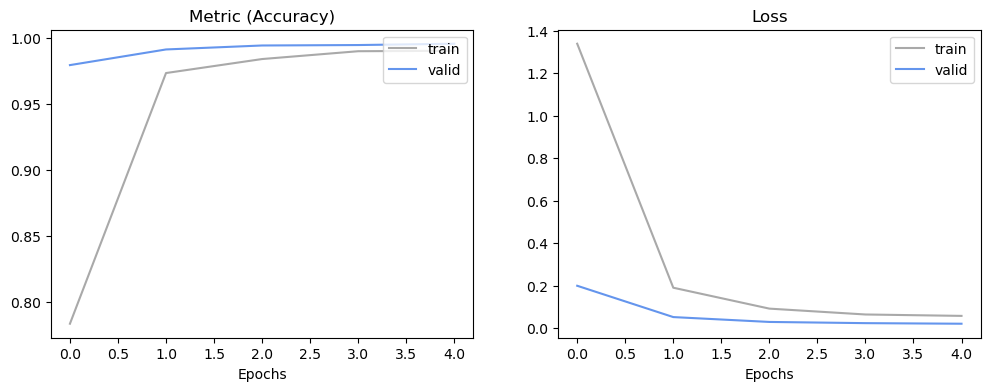

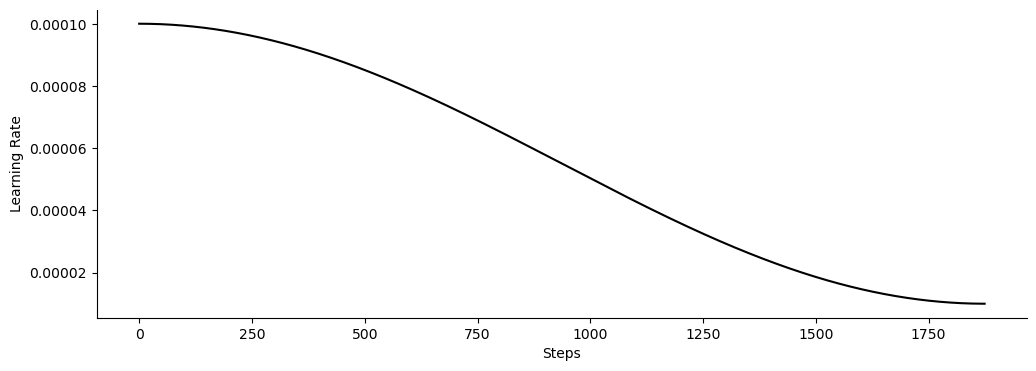

Epoch 1/5


100%|██████████| 188/188 [00:19<00:00,  9.56it/s]


Loss: 1.3376 Acc: 0.7557
Val Loss: 0.2247 Val Acc: 0.9723
Epoch 2/5


100%|██████████| 188/188 [00:20<00:00,  9.34it/s]


Loss: 0.1990 Acc: 0.9700
Val Loss: 0.0584 Val Acc: 0.9915
Epoch 3/5


100%|██████████| 188/188 [00:19<00:00,  9.52it/s]


Loss: 0.0930 Acc: 0.9846
Val Loss: 0.0325 Val Acc: 0.9940
Epoch 4/5


100%|██████████| 188/188 [00:19<00:00,  9.51it/s]


Loss: 0.0650 Acc: 0.9882
Val Loss: 0.0258 Val Acc: 0.9952
Epoch 5/5


100%|██████████| 188/188 [00:19<00:00,  9.52it/s]


Loss: 0.0608 Acc: 0.9894
Val Loss: 0.0236 Val Acc: 0.9957


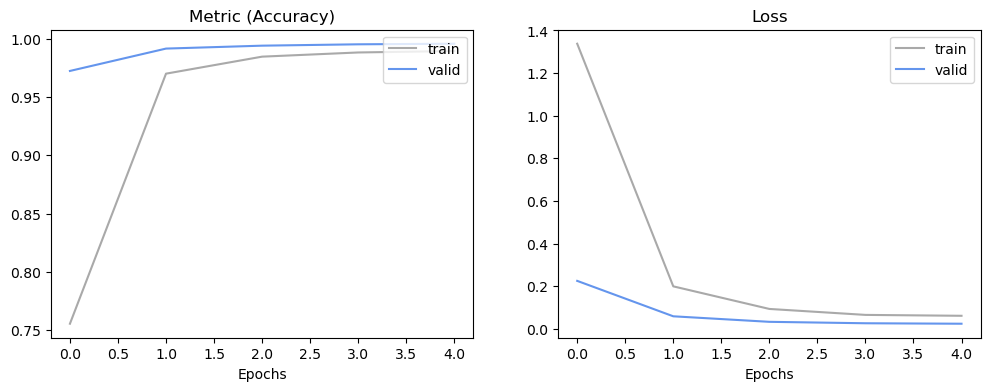

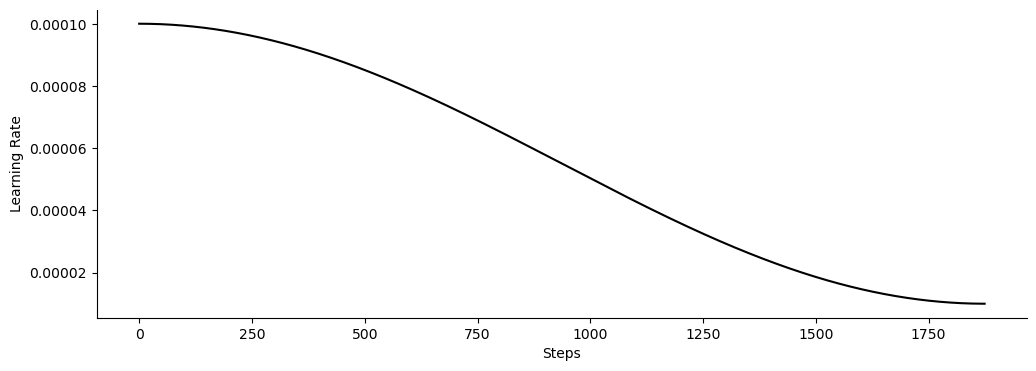

Epoch 1/5


100%|██████████| 188/188 [00:21<00:00,  8.74it/s]


Loss: 1.3417 Acc: 0.7658
Val Loss: 0.2016 Val Acc: 0.9777
Epoch 2/5


100%|██████████| 188/188 [00:19<00:00,  9.72it/s]


Loss: 0.1964 Acc: 0.9707
Val Loss: 0.0460 Val Acc: 0.9947
Epoch 3/5


100%|██████████| 188/188 [00:19<00:00,  9.61it/s]


Loss: 0.0903 Acc: 0.9854
Val Loss: 0.0264 Val Acc: 0.9958
Epoch 4/5


100%|██████████| 188/188 [00:19<00:00,  9.67it/s]


Loss: 0.0636 Acc: 0.9888
Val Loss: 0.0214 Val Acc: 0.9967
Epoch 5/5


100%|██████████| 188/188 [00:19<00:00,  9.68it/s]


Loss: 0.0589 Acc: 0.9893
Val Loss: 0.0199 Val Acc: 0.9973


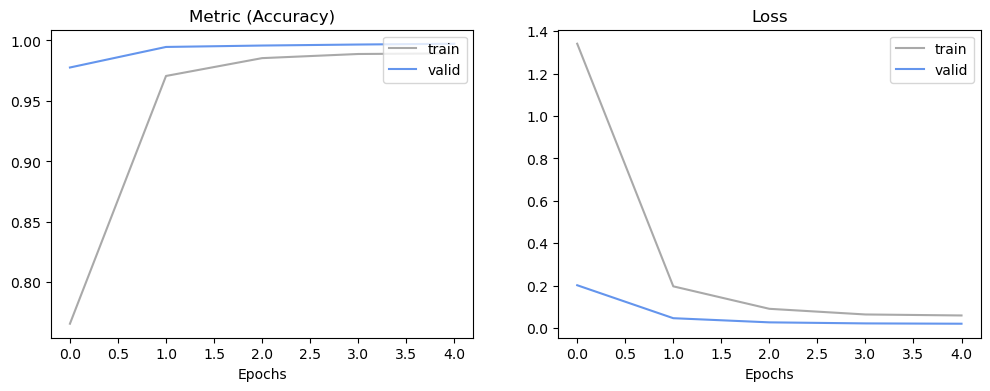

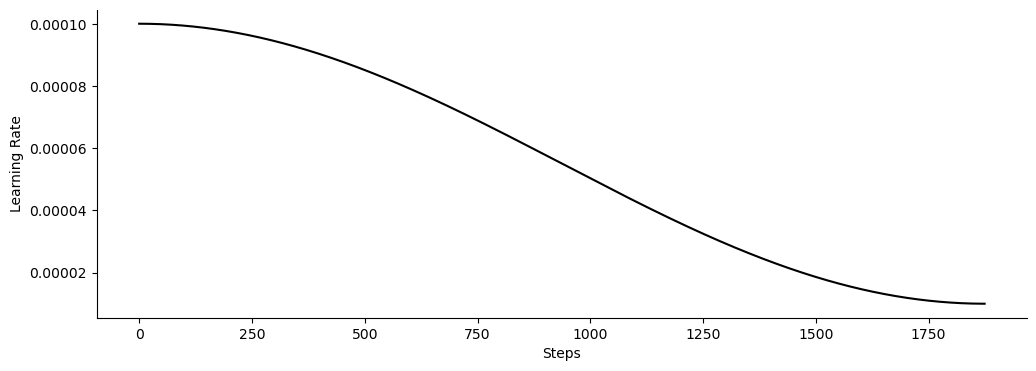

In [65]:
# Create a new column for cross-validation folds
df["kfold"] = -1  # initialized with a value of -1 for all rows.

# Initialize the kfold class
skf = StratifiedKFold(n_splits=cfg.n_folds,shuffle=True, random_state=42)  # This class provides functionality for generating the indices of the train and validation data for each fold.

# Perform stratified k-fold
for fold, (train_indices, val_indices) in enumerate(skf.split(X=df, y=df['label'])): #splits the data into train and validation indices for each fold, based on the class labels (df['label']). 
    #It returns an iterator yielding pairs of train and validation indices.
    df.loc[val_indices, "kfold"] = fold  #For each fold, the loop assigns the fold number fold to the "kfold" column for the validation indices (val_indices) in the dataframe (df). 
    #This assigns the fold number to the corresponding rows of the validation data.

        
for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = CustomDataset(cfg, train_df, transform = transform_soft)
    valid_dataset = CustomDataset(cfg, valid_df)

    train_dataloader = DataLoader(train_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers = 0,
                             )
    valid_dataloader = DataLoader(valid_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = False, 
                              num_workers = 0,
                             )
    model = timm.create_model(cfg.backbone, 
                              pretrained = True, 
                              num_classes = cfg.n_classes)
    
    model = model.to(cfg.device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = cfg.learning_rate, 
                                 weight_decay = 0,
                                )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                           T_max= np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
                                                           eta_min=cfg.lr_min)
    acc, loss, val_acc, val_loss, model, lrs = fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader)
    
    visualize_history(acc, loss, val_acc, val_loss)

    fig, ax = plt.subplots(1,1, figsize=(12,4))
    ax.plot(range(len(lrs)),lrs,  color='black')

    ax.set_xlabel('Steps')
    ax.set_ylabel('Learning Rate')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.savefig(f'/kaggle/working/learning_rate.jpg', transparent=False,  facecolor='white')

    plt.show()
    
    

First, let’s fine-tune the model with the optimal configuration on the full dataset to take advantage of every data sample. We don’t split the data into training and validation data in this step. Instead, we only have one big training dataset.

In [66]:
train_df = df.copy()

train_dataset = CustomDataset(cfg, train_df, transform = transform_soft)

train_dataloader = DataLoader(train_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = True, 
                          num_workers = 0,
                         )

model = timm.create_model(cfg.backbone, 
                          pretrained = True, 
                          num_classes = cfg.n_classes)

model = model.to(cfg.device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr = cfg.learning_rate, 
                             weight_decay = 0,
                            )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max= np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
                                                       eta_min=cfg.lr_min)

acc, loss, val_acc, val_loss, model, lrs = fit(model, optimizer, scheduler, cfg, train_dataloader)

Epoch 1/5


100%|██████████| 563/563 [01:17<00:00,  7.23it/s]


Loss: 0.9568 Acc: 0.8355
Epoch 2/5


100%|██████████| 563/563 [01:14<00:00,  7.51it/s]


Loss: 0.0963 Acc: 0.9846
Epoch 3/5


100%|██████████| 563/563 [01:09<00:00,  8.09it/s]


Loss: 0.0508 Acc: 0.9909
Epoch 4/5


100%|██████████| 563/563 [01:07<00:00,  8.33it/s]


Loss: 0.0380 Acc: 0.9927
Epoch 5/5


100%|██████████| 563/563 [01:05<00:00,  8.56it/s]

Loss: 0.0297 Acc: 0.9947


### FLOW CHART

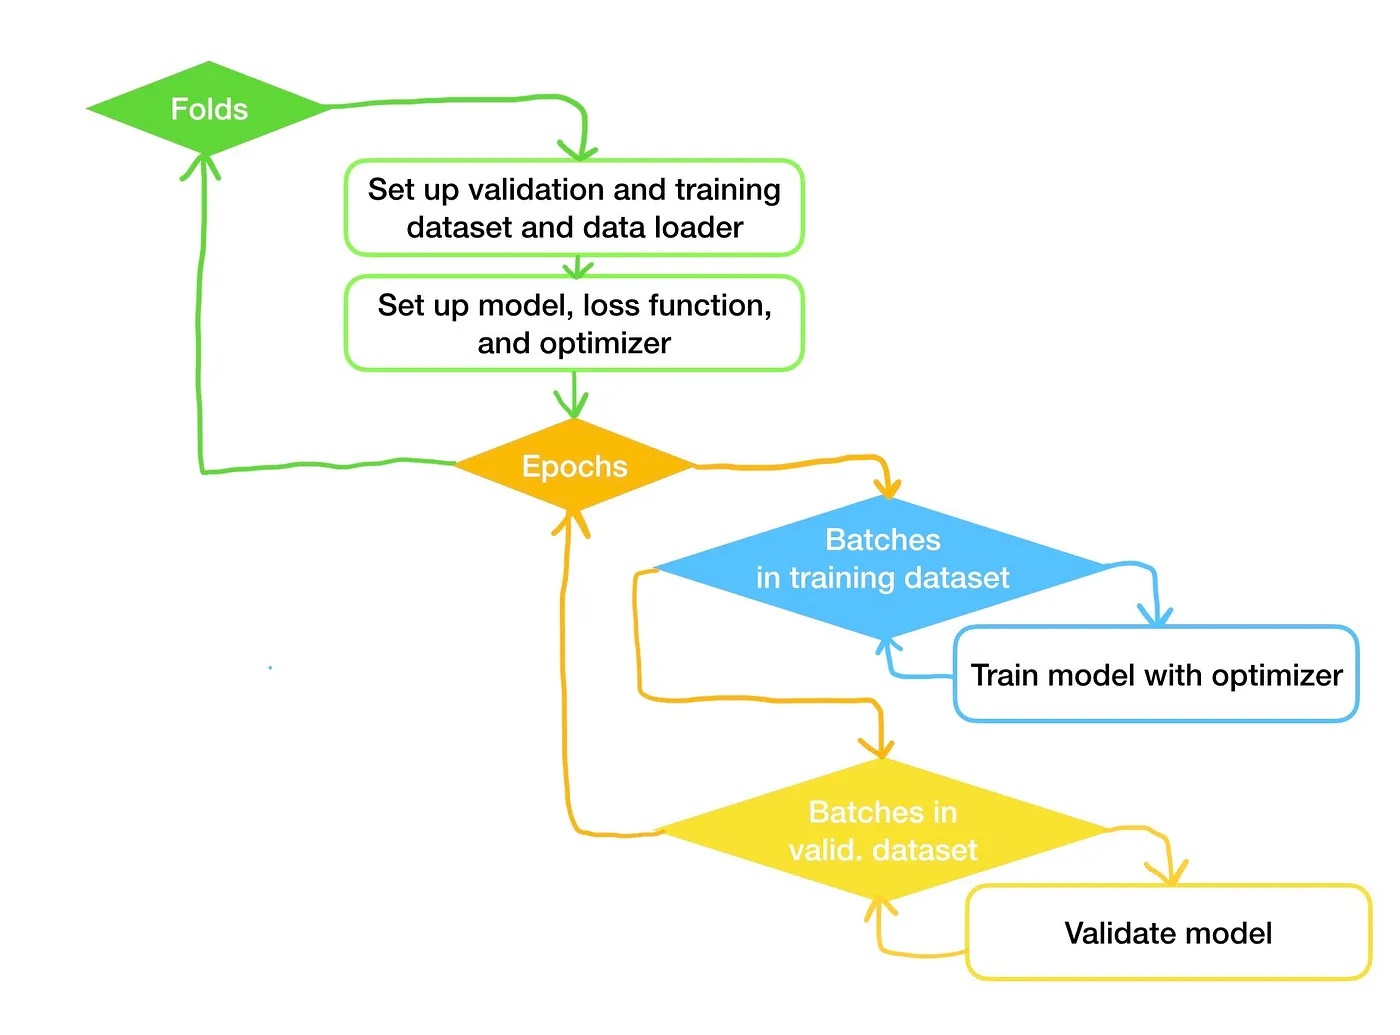

### Testng on test dataset

In [67]:
test_dataset = CustomDataset(cfg, test_df)

test_dataloader = DataLoader(test_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = False, 
                          num_workers = 0,
                         )


#def predict(dataloader, model, cfg):
dataloader = test_dataloader
# Validation mode
model.eval()

final_y = []
final_y_pred = []

# Iterate over data
for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    X = batch[0].to(cfg.device)
    y = batch[1].to(cfg.device)

    with torch.no_grad():
        # Forward: Get model outputs
        y_pred = model(X)

        # Covert y and y_pred to lists
        y =  y.detach().cpu().numpy().tolist()
        y_pred =  y_pred.detach().cpu().numpy().tolist()

        # Extend original list
        final_y.extend(y)
        final_y_pred.extend(y_pred)

# Calculate statistics
final_y_pred_argmax = np.argmax(final_y_pred, axis=1)
metric = calculate_metric(final_y, final_y_pred_argmax)
print(metric)
#return metric, loss

100%|██████████| 94/94 [00:33<00:00,  2.83it/s]

0.9986666666666667


In [68]:
calculate_metric(final_y, final_y_pred_argmax)

0.9986666666666667

In [69]:
test_df['prediction'] = final_y_pred_argmax
test_df

file_name  label  prediction
0     Broccoli/1075.jpg      0           0
1     Broccoli/1031.jpg      0           0
2     Broccoli/1024.jpg      0           0
3     Broccoli/1161.jpg      0           0
4     Broccoli/1009.jpg      0           0
...                 ...    ...         ...
2995    Potato/1135.jpg     14          14
2996    Potato/1399.jpg     14          14
2997    Potato/1021.jpg     14          14
2998    Potato/1015.jpg     14          14
2999    Potato/1141.jpg     14          14

[3000 rows x 3 columns]

In [70]:
len(test_df[test_df['prediction']!=test_df['label']])

4